# 2021 2학기 영상처리 기말프로젝트
### Image segmentation
--- 
* 201937437 이가은
* 201738407 김상민

# 1. Libraries import

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
import cv2
import os
from tensorflow.keras import layers
%matplotlib inline
import glob
import random
from skimage.util import random_noise 


# 2. Image load

In [2]:
# 1. 그림 불러오기
original_img  = plt.imread('./Original/train/18-40-04-05 (ENF).jpg')
label_img = plt.imread('./Labeling/train/18-40-04-05 (ENF)_image.png')

(1200, 1600, 3)
(1200, 1600, 3)


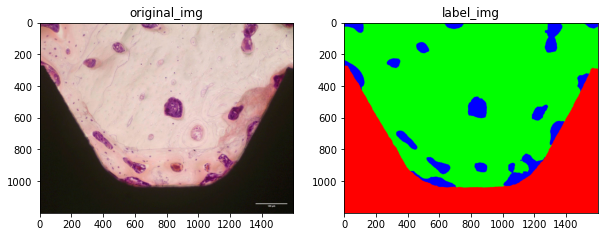

In [3]:
# 2. 이미지 불러오기
plt.figure(figsize = (10, 10))
plt.subplot(121), plt.imshow(original_img), plt.title("original_img")
plt.subplot(122), plt.imshow(label_img), plt.title("label_img")

print(original_img.shape)
print(label_img.shape)

# 3. Various Image Augmentation

### 1) Rotation Augmentation
* matrix = cv2.getRotationMatrix2D(center, angle, scale)는 중심점(center), 각도(angle), 비율(scale)로 매핑 변환 행렬(matrix)을 생성
* dst = cv2.warpAffine(src, M, dsize)는 원본 이미지(src)에 M(아핀 맵 행렬)을 적용하고 출력 이미지 크기(dsize)로 변형해서 출력 이미지(dst)를 반환

In [4]:
def rotation(orinigal, label, angle):
    # load the image
    rotation_ori = original_img.copy()
    rotation_lab = label_img.copy()
    
    angle = int(random.uniform(-angle, angle))
    h, w = rotation_ori.shape[:2]
    M = cv2.getRotationMatrix2D((int(w/2), int(h/2)), angle, 1)

    dx, dy = 100, 50            # 이동할 픽셀 거리

    # -- 탈락된 외곽 픽셀을 원본을 반사 시켜서 보정
    rotation_original = cv2.warpAffine(rotation_ori,  M, (w+dx, h+dy), None, \
                                cv2.INTER_LINEAR, cv2.BORDER_REFLECT)
    rotation_label = cv2.warpAffine(rotation_lab,  M, (w+dx, h+dy), None, \
                                cv2.INTER_LINEAR, cv2.BORDER_REFLECT)

    # resize
    rotation_original = cv2.resize(rotation_original, (1600,1200))
    rotation_label = cv2.resize(rotation_label, (1600,1200))
    
    print("-------------------------rotation-------------------------")
    plt.figure()
    plt.subplot(121), plt.imshow(rotation_original), plt.title("rotation's original_img")
    plt.subplot(122), plt.imshow(rotation_label), plt.title("rotation's label_img")

    print(rotation_original.shape)
    print(rotation_label.shape)
    
    #return rotation_original, rotataion_label

### 2) flips Augmentation
* cv2.flip(src, flipCode, dst=None) -> src: 입력 영상, flipCode: 대칭 방향 지정, dst: 출력 영상
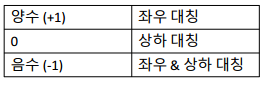

In [5]:
def vertical_flip(orinigal, label):
    # load the image
    vflip_ori = original_img.copy()
    vflip_lab = label_img.copy()

    vflip_original = cv2.flip(vflip_ori, 0)
    vflip_label = cv2.flip(vflip_lab, 0)
    print("-------------------------vertical_flip-------------------------")
    plt.figure()
    plt.subplot(121), plt.imshow(vflip_original), plt.title("vertical_flip's original_img")
    plt.subplot(122), plt.imshow(vflip_label), plt.title("vertical_flip's label_img")

    print(vflip_original.shape)
    print(vflip_label.shape)

    #return vflip_original, vflip_label

In [6]:
def horizontal_flip(orinigal, label):
    # load the image
    hflip_ori = original_img.copy()
    hflip_lab = label_img.copy()

    hflip_original = cv2.flip(hflip_ori, 1)
    hflip_label = cv2.flip(hflip_lab, 1)
    print("-------------------------horizontal_flip-------------------------")
    plt.figure()
    plt.subplot(121), plt.imshow(hflip_original), plt.title("horizontal_flip's original_img")
    plt.subplot(122), plt.imshow(hflip_label), plt.title("horizontal_flip's label_img")

    print(hflip_original.shape)
    print(hflip_label.shape)
    
    #return hflip_original, hflip_label

In [7]:
def v_h_flip(orinigal, label):
    # load the image
    vhflip_ori = original_img.copy()
    vhflip_lab = label_img.copy()

    hflip_original = cv2.flip(vhflip_ori, 1)
    hflip_label = cv2.flip(vhflip_lab, 1)

    vhflip_original = cv2.flip(hflip_original, 0)
    vhflip_label = cv2.flip(hflip_label, 0)
    print("-------------------------v_h_flip-------------------------")
    plt.figure()
    plt.subplot(121), plt.imshow(vhflip_original), plt.title("v_h_flip's original_img")
    plt.subplot(122), plt.imshow(vhflip_label), plt.title("v_h_flip's label_img")

    print(vhflip_original.shape)
    print(vhflip_label.shape)
    
    #return vhflip_original, vhflip_label

### 3) translate Augmentation

In [8]:
def translate(original, label, x, y):
    # load the image
    translate_ori = original_img.copy()
    translate_lab = label_img.copy()
    
    rows, cols = translate_ori.shape[0:2]  # 영상의 크기
    rows1, cols1 = translate_lab.shape[0:2]  # 영상의 크기

    # x, y = 이동할 픽셀 거리에 곱할 퍼센트

    dx = int(original.shape[1]*(x/100))
    dy = int(original.shape[0]*(y/100))

    # ---① 변환 행렬 생성 
    mtrx = np.float32([[1, 0, dx],
                   [0, 1, dy]])
    
    # ---② 탈락된 외곽 픽셀을 원본을 반사 시켜서 보정
    translate_original = cv2.warpAffine(translate_ori, mtrx, (cols+dx, rows+dy), None, \
                                  cv2.INTER_LINEAR, cv2.BORDER_REFLECT)
    translate_label = cv2.warpAffine(translate_lab, mtrx, (cols+dx, rows+dy), None, \
                                  cv2.INTER_LINEAR, cv2.BORDER_REFLECT)
    
    translate_original = cv2.resize(translate_original, (1600,1200))
    translate_label = cv2.resize(translate_label, (1600,1200))
    print("-------------------------translate-------------------------")
    plt.figure()
    plt.subplot(121), plt.imshow(translate_original), plt.title("translate's original_img")
    plt.subplot(122), plt.imshow(translate_label), plt.title("translate's label_img")

    print(translate_original.shape)
    print(translate_label.shape)
    
    #return translate_original, translate_label

### 4) Brightness Augmentation
* HSV 색상 공간을 사용
* Saturation 및 Value 매트릭스의 값이 클수록 밝기가 커진다
* 밝기를 높이려면 1보다 큰 값을 곱하고 밝기를 줄이려면 1보다 작은 값을 지정
* Tensorflow에서는 범위가 지정되고 그 사이에서 임의의 값이 선택됨

In [9]:
def brightness(original, label, low, high):
    # load the image
    bright_ori = original_img.copy()
    bright_lab = label_img.copy()

    value = random.uniform(low, high)
    hsv = cv2.cvtColor(bright_ori, cv2.COLOR_BGR2HSV)
    hsv = np.array(hsv, dtype = np.float64)
    hsv[:,:,1] = hsv[:,:,1]*value
    hsv[:,:,1][hsv[:,:,1]>255]  = 255
    hsv[:,:,2] = hsv[:,:,2]*value 
    hsv[:,:,2][hsv[:,:,2]>255]  = 255
    hsv = np.array(hsv, dtype = np.uint8)

    hsv1 = cv2.cvtColor(bright_lab, cv2.COLOR_BGR2HSV)
    hsv1 = np.array(hsv1, dtype = np.float64)
    hsv1[:,:,1] = hsv1[:,:,1]*value
    hsv1[:,:,1][hsv1[:,:,1]>255]  = 255
    hsv1[:,:,2] = hsv1[:,:,2]*value 
    hsv1[:,:,2][hsv1[:,:,2]>255]  = 255
    hsv1 = np.array(hsv1, dtype = np.uint8)

    bright_original = cv2.cvtColor(hsv, cv2.COLOR_HSV2BGR)
    bright_label = cv2.cvtColor(hsv1, cv2.COLOR_HSV2BGR)

    print("-------------------------Brightness-------------------------")
    plt.figure()
    plt.subplot(121), plt.imshow(bright_original), plt.title("Brightness's original_img")
    plt.subplot(122), plt.imshow(bright_label), plt.title("Brightness's label_img")

    print(bright_original.shape)
    print(bright_label.shape)

### 5) Zoom Augmentation
* Tensorflow에서 확대/축소 기능은 범위를 취하고 그 사이에 임의의 값을 사용
* 해당 값이 1보다 작으면 이미지를 확대하고 1보다 큰 값은 축소하고 '가장 가까운' 것으로 채움

In [10]:
def zoom(original, label, value):
    # load the image
    zoom_ori = original_img.copy()
    zoom_lab = label_img.copy()

    if value > 1 or value < 0.8:
        print('Value for zoom should be less than 1 and greater than 0')
        #return zoom_ori, zoom_lab

    #value = random.uniform(value, 1)
    h, w = zoom_ori.shape[:2]
    h_taken = int(value*h) // 2
    w_taken = int(value*w) // 2
    """h_start = random.randint(0, h-h_taken)
    w_start = random.randint(0, w-w_taken)"""
    h_start = 600
    w_start = 800

    zoom_original = zoom_ori[h_start-h_taken:h_start, w_start-w_taken:w_start, :]
    zoom_label = zoom_lab[h_start-h_taken:h_start, w_start-w_taken:w_start, :]

    zoom_original = cv2.resize(zoom_original, (1600,1200))
    zoom_label = cv2.resize(zoom_label, (1600,1200))
    print("-------------------------zoom-------------------------")
    plt.figure()
    plt.subplot(121), plt.imshow(zoom_original), plt.title("zoom's original_img")
    plt.subplot(122), plt.imshow(zoom_label), plt.title("zoom's label_img")

    print(zoom_original.shape)
    print(zoom_label.shape)
    
    #return zoom_original, zoom_label

### 6) channel_shift
* 채널 이동에서는 지정된 범위에서 선택한 이미지의 모든 채널에 임의의 값이 추가
* 그 결과는 밝기 기능과 다소 비슷

In [11]:
def channel_shift(orinigal, label, value):
    # load the image
    Shifts_ori = original_img.copy()
    Shifts_lab = label_img.copy()

    value = int(random.uniform(-value, value))
    Shifts_ori = Shifts_ori + value
    Shifts_ori[:,:,:][Shifts_ori[:,:,:]>255]  = 255
    Shifts_ori[:,:,:][Shifts_ori[:,:,:]<0]  = 0
    Shifts_original = Shifts_ori.astype(np.uint8)

    Shifts_lab = Shifts_lab + value
    Shifts_lab[:,:,:][Shifts_lab[:,:,:]>255]  = 255
    Shifts_lab[:,:,:][Shifts_lab[:,:,:]<0]  = 0
    Shifts_label = Shifts_lab.astype(np.uint8)

    print("-------------------------channel_shift-------------------------")
    plt.figure()
    plt.subplot(121), plt.imshow(Shifts_original), plt.title("channel_shift's original_img")
    plt.subplot(122), plt.imshow(Shifts_label), plt.title("channel_shift's label_img")

    print(Shifts_original.shape)
    print(Shifts_label.shape)

In [12]:
def noisyRandom(orinigal, label, sigma):
    # load the image
    random_ori = original_img.copy()
    random_lab = label_img.copy()

    random_original = random_noise(random_ori,var=sigma**2)
    random_label = random_noise(random_lab,var=sigma**2)

    print("-------------------------noisyRandom-------------------------")
    plt.figure()
    plt.subplot(121), plt.imshow(random_original), plt.title("noisyRandom's original_img")
    plt.subplot(122), plt.imshow(random_label), plt.title("noisyRandom's label_img")

    print(random_original.shape)
    print(random_label.shape)

# 4. 실행

-------------------------rotation-------------------------
(1200, 1600, 3)
(1200, 1600, 3)


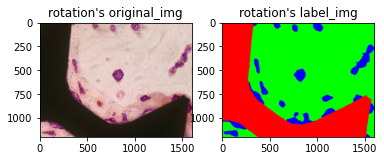

In [13]:
rotation(original_img, label_img, 70)

-------------------------vertical_flip-------------------------
(1200, 1600, 3)
(1200, 1600, 3)


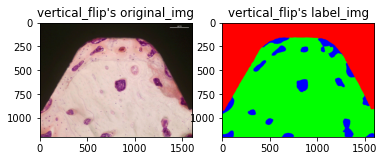

In [14]:
vertical_flip(original_img, label_img)

-------------------------horizontal_flip-------------------------
(1200, 1600, 3)
(1200, 1600, 3)


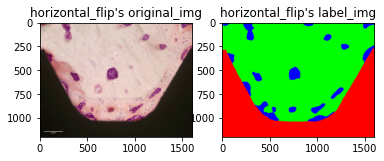

In [15]:
horizontal_flip(original_img, label_img)

-------------------------v_h_flip-------------------------
(1200, 1600, 3)
(1200, 1600, 3)


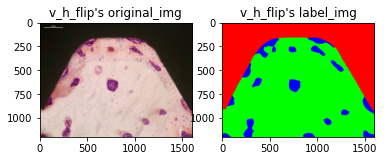

In [16]:
v_h_flip(original_img, label_img)

-------------------------translate-------------------------
(1200, 1600, 3)
(1200, 1600, 3)


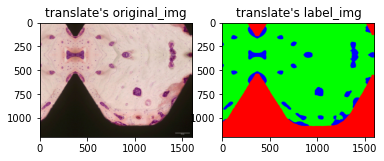

In [17]:
translate(original_img, label_img, 30, 40)

-------------------------Brightness-------------------------
(1200, 1600, 3)
(1200, 1600, 3)


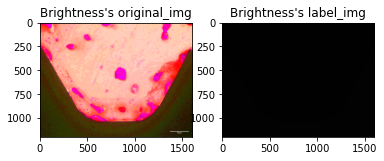

In [18]:
brightness(original_img, label_img, 0.5, 4)

Value for zoom should be less than 1 and greater than 0
-------------------------zoom-------------------------
(1200, 1600, 3)
(1200, 1600, 3)


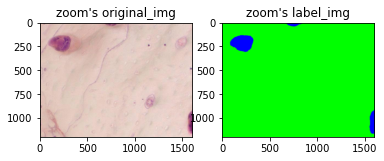

In [19]:
zoom(original_img, label_img, 0.7)

-------------------------channel_shift-------------------------
(1200, 1600, 3)
(1200, 1600, 3)


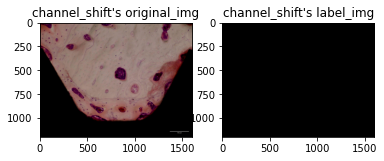

In [20]:
channel_shift(original_img, label_img, 77)

-------------------------noisyRandom-------------------------
(1200, 1600, 3)
(1200, 1600, 3)


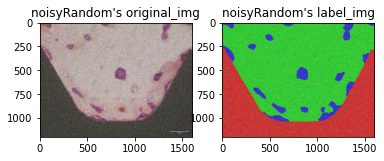

In [21]:
noisyRandom(original_img, label_img, 0.55)

## 이 중 rotation, flip, translation, zoom을 사용하기로 함!

## ============================================

# 5. 패치

In [22]:
train_save_path = '.\\result\\train\\'
label_save_path = '.\\result\\label\\'

In [28]:
def crop_image(img, name, save_path, j, k):
    
    img_result = img[j*128 : (j+1)*128, k*128 : (k+1)*128]
    #print(img_result.shape)

    if img_result.shape[1]!=128 or img_result.shape[0]!=128:
        print('image save has passed')
        pass
    
    else:
        new_save_path = save_path + str(name) + '_' + str(j) + '_' + str(k) + '_augmented_' + '.png'
        print(new_save_path)
        plt.imsave(new_save_path, img_result)

In [ ]:
train_x = []
train_y = []

crop_value_1 = original_img.shape[1]//128
crop_value_2 = original_img.shape[0]//128

for j in range(crop_value_1):
    for k in range(crop_value_2):
        crop_image(original_img, 'img', train_save_path, j, k)
        crop_image(label_img, 'label', label_save_path, j, k)

# 6. 실행


********************************************************************
[Augmentation]
1 . rotation
2 . flips
3 . translate
4 . zoom

********************************************************************


## 사용하고 싶은 Augmentation 를 입력하세요 ( Augmentation 그림 확인 : 0) :  1


********************************************************************


## rotation 하고 싶은 각도를 입력하세요 ! (-360 ~ +360) :  30


-------------------------rotation-------------------------
(1200, 1600, 3)
(1200, 1600, 3)

********************************************************************
[Augmentation]
1 . rotation
2 . flips
3 . translate
4 . zoom

********************************************************************


## 사용하고 싶은 Augmentation 를 입력하세요 ( Augmentation 그림 확인 : 0) :  2


********************************************************************
## horizontal_flip 을 실행합니다.
-------------------------horizontal_flip-------------------------
(1200, 1600, 3)
(1200, 1600, 3)

********************************************************************
[Augmentation]
1 . rotation
2 . flips
3 . translate
4 . zoom

********************************************************************


## 사용하고 싶은 Augmentation 를 입력하세요 ( Augmentation 그림 확인 : 0) :  3


********************************************************************


## translate 하고 싶은 x, y 비율을 입력하세요 ! (0 ~ 100) :  40 20


-------------------------translate-------------------------
(1200, 1600, 3)
(1200, 1600, 3)

********************************************************************
[Augmentation]
1 . rotation
2 . flips
3 . translate
4 . zoom

********************************************************************


## 사용하고 싶은 Augmentation 를 입력하세요 ( Augmentation 그림 확인 : 0) :  0


## 끝 ! 


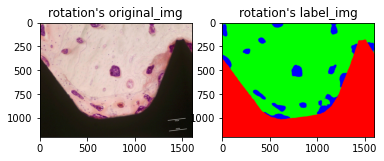

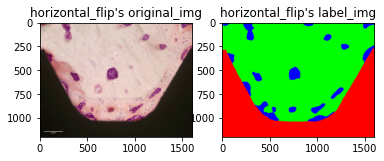

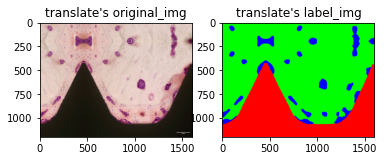

In [23]:
def show():   
    print()
    print("********************************************************************")
    print("[Augmentation]")
    for i in range(0, len(Augmentation)):
        print(i+1, ".", Augmentation[i])
    print()

 
if __name__ == '__main__':
 
    Augmentation = ("rotation", "flips", "translate", "zoom")

    while True:
        show()
        print("********************************************************************")
        num = int(input("## 사용하고 싶은 Augmentation 를 입력하세요 ( Augmentation 그림 확인 : 0) : "))
        if num == 0:
           print("## 끝 ! ")
           break;
        elif(num == 1):
           print("********************************************************************")
           value = int(input("## rotation 하고 싶은 각도를 입력하세요 ! (-360 ~ +360) : "))
           rotation(original_img, label_img, value)
        elif(num == 2):
           print("********************************************************************")
           print("## horizontal_flip 을 실행합니다.")
           horizontal_flip(original_img, label_img)
        elif(num == 3):
           print("********************************************************************")
           x, y = map(int,input("## translate 하고 싶은 x, y 비율을 입력하세요 ! (0 ~ 100) : ").split())
           translate(original_img, label_img, x, y)
        elif(num == 4):
           print("********************************************************************")
           value == float(input("## zoom 하고 싶은 비율을 입력하세요 ! (0 ~ 1) : "))
           zoom(original_img, label_img, value)
        else:
           print("********************************************************************")
           print("## 잘못된 번호입니다")

# 함수화 및 test

In [24]:
def crop_image(img, name, save_path, j, k):
    
    img_result = img[j*128 : (j+1)*128, k*128 : (k+1)*128]
    #print(img_result.shape)

    if img_result.shape[1]!=128 or img_result.shape[0]!=128:
        print('image save has passed')
        pass
    
    else:
        new_save_path = save_path + str(name) + '_' + str(j) + '_' + str(k) + '_augmented_' + '.png'
        print(new_save_path)
        plt.imsave(new_save_path, img_result)

In [25]:
def augmentation(img, label):
    rot_value = int(input("## rotation 하고 싶은 각도를 입력하세요. (-360 ~ +360) : "))
    zoom_value = float(input("## zoom 하고 싶은 비율을 입력하세요. (0 ~ 1) : "))
    x, y = map(int,input("## translate 하고 싶은 x, y 비율을 입력하세요. (0 ~ 100, 예: 20 40) : ").split())
    
    random_value = np.random.randint(0, 100)
    
    train_save_path = '.\\result\\train\\'
    label_save_path = '.\\result\\label\\'
    
    # 나머지가 1일 경우, rotation만
    if random_value // 4 == 1:
        
        print("Mode 1 activated")
        
        rotation(img, label, rot_value)
        
        img = rotation_original
        label = rotataion_label
        
        # 위의 random value가 짝수일 경우, 이미지 flip을 진행.
        if random_value//2 == 0:
            horizontal_flip(img, label)

        img = hflip_original
        label = hflip_label

        crop_value_1 = img.shape[1]//128
        crop_value_2 = img.shape[0]//128

        for j in range(crop_value_1):
            for k in range(crop_value_2):
                crop_image(img, 'img', train_save_path, j, k)
                crop_image(label, 'label', label_save_path, j, k)

    # 나머지가 2일 경우, rotation & translation
    elif random_value // 4 == 2:
        
        print("Mode 2 activated")
        
        rotation(img, label, rot_value)
        translate(rotation_original, rotation_label, x, y)
        
        img = translate_original
        label = translate_label
        
        # 위의 random value가 짝수일 경우, 이미지 flip을 진행.
        if random_value//2 == 0:
            horizontal_flip(img, label)

        img = hflip_original
        label = hflip_label
    
        crop_value_1 = img.shape[1]//128
        crop_value_2 = img.shape[0]//128

        for j in range(crop_value_1):
            for k in range(crop_value_2):
                crop_image(img, 'img', train_save_path, j, k)
                crop_image(label, 'label', label_save_path, j, k)


    # 나머지가 2일 경우, rotation & translation & zoom
    elif random_value // 4 == 3:
        
        print("Mode 3 activated")
        
        rotation(img, label, rot_value)
        translate(rotation_original, rotation_label, x, y)
        zoom(translate_original, translate_label, zoom_value)
        
        img = zoom_label
        label = zoom_label
        
        if random_value//2 == 0:
            horizontal_flip(img, label)

        # 위의 random value가 짝수일 경우, 이미지 flip을 진행.
        img = hflip_original
        label = hflip_label
    
        crop_value_1 = img.shape[1]//128
        crop_value_2 = img.shape[0]//128

        for j in range(crop_value_1):
            for k in range(crop_value_2):
                crop_image(img, 'img', train_save_path, j, k)
                crop_image(label, 'label', label_save_path, j, k)

    
    # 나머지일 경우, 이미지를 그대로 낸다.
    else:
        
        print("Mode 4 activated")
        
        pass
    
        crop_value_1 = img.shape[1]//128
        crop_value_2 = img.shape[0]//128

        for j in range(crop_value_1):
            for k in range(crop_value_2):
                crop_image(img, 'img', train_save_path, j, k)
                crop_image(label, 'label', label_save_path, j, k)

In [26]:
augmentation(original_img, label_img)

## rotation 하고 싶은 각도를 입력하세요. (-360 ~ +360) :  20
## zoom 하고 싶은 비율을 입력하세요. (0 ~ 1) :  0.95
## translate 하고 싶은 x, y 비율을 입력하세요. (0 ~ 100, 예: 20 40) :  40 20


Mode 4 activated
.\result\train\img_0_0_augmented_.png
.\result\label\label_0_0_augmented_.png
.\result\train\img_0_1_augmented_.png
.\result\label\label_0_1_augmented_.png
.\result\train\img_0_2_augmented_.png
.\result\label\label_0_2_augmented_.png
.\result\train\img_0_3_augmented_.png
.\result\label\label_0_3_augmented_.png
.\result\train\img_0_4_augmented_.png
.\result\label\label_0_4_augmented_.png
.\result\train\img_0_5_augmented_.png
.\result\label\label_0_5_augmented_.png
.\result\train\img_0_6_augmented_.png
.\result\label\label_0_6_augmented_.png
.\result\train\img_0_7_augmented_.png
.\result\label\label_0_7_augmented_.png
.\result\train\img_0_8_augmented_.png
.\result\label\label_0_8_augmented_.png
.\result\train\img_1_0_augmented_.png
.\result\label\label_1_0_augmented_.png
.\result\train\img_1_1_augmented_.png
.\result\label\label_1_1_augmented_.png
.\result\train\img_1_2_augmented_.png
.\result\label\label_1_2_augmented_.png
.\result\train\img_1_3_augmented_.png
.\result\